# Fair Data Splitting for Model Comparison

## Why Consistent Data Splits Matter

When comparing multiple machine learning models, each model must be evaluated on exactly the same data to ensure fair comparison. When using different splits for different models, any performance differences could be due to test difficulty rather than actual capability.

For this fake news detection project, I'll create a single set of train/validation/test splits that all models will use. This ensures that performance differences reflect genuine model capabilities rather than data distribution luck.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure plots
plt.style.use('ggplot')
sns.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Environment ready. Using random seed: {RANDOM_SEED}")

Environment ready. Using random seed: 42


## Load and Explore the Dataset

In [2]:
# Load the cleaned WELFake dataset
df = pd.read_csv('../data/WELFake_cleaned.csv')

# Create combined text feature for consistency across all models
df['combined_text'] = df['title'] + " " + df['text']

print(f"Dataset loaded: {len(df):,} articles")
print(f"Features: {list(df.columns)}")

Dataset loaded: 71,537 articles
Features: ['Unnamed: 0', 'title', 'text', 'label', 'combined_text']


In [3]:
# Check class distribution
class_counts = df['label'].value_counts()
fake_ratio = df['label'].mean()

print(f"\nClass Distribution:")
print(f"Real news (0): {class_counts[0]:,} ({(1-fake_ratio)*100:.1f}%)")
print(f"Fake news (1): {class_counts[1]:,} ({fake_ratio*100:.1f}%)")


Class Distribution:
Real news (0): 35,028 (49.0%)
Fake news (1): 36,509 (51.0%)


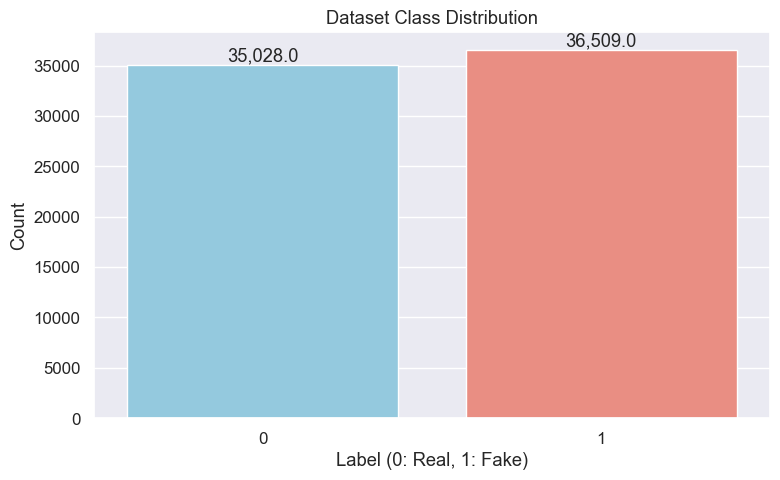

In [4]:
# Visualize class balance
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df, palette=['skyblue', 'salmon'])
plt.title('Dataset Class Distribution')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Create Stratified Splits

The key insight here is using stratified sampling to maintain class balance across all splits. This prevents any split from being accidentally biased toward one class.

In [5]:
def create_splits(df, test_size=0.15, val_size=0.15, random_state=42):
    """
    Create stratified train/validation/test splits.
    
    Returns:
        train_df, val_df, test_df: DataFrames for each split
        split_indices: Dictionary containing indices used in each split
    """
    X = df['combined_text']
    y = df['label']
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second split: divide temp into train/val
    adjusted_val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=adjusted_val_size, 
        random_state=random_state, stratify=y_temp
    )
    
    # Create DataFrames using original indices
    train_df = df.loc[X_train.index].reset_index(drop=True)
    val_df = df.loc[X_val.index].reset_index(drop=True)
    test_df = df.loc[X_test.index].reset_index(drop=True)

    # Return also the raw index sets
    index_dict = {
        'train_idx': set(X_train.index),
        'val_idx': set(X_val.index),
        'test_idx': set(X_test.index)
    }
    
    return train_df, val_df, test_df, index_dict

In [6]:
# Create the splits
train_df, val_df, test_df, split_indices = create_splits(df, random_state=RANDOM_SEED)

print(f"Splits created:")
print(f"Train: {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test: {len(test_df):,} samples ({len(test_df)/len(df)*100:.1f}%)")

Splits created:
Train: 50,075 samples (70.0%)
Validation: 10,731 samples (15.0%)
Test: 10,731 samples (15.0%)


## Verify Split Quality

In [7]:
# Check class balance in each split
splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

print("Class balance verification:")
for name, split_df in splits.items():
    fake_pct = split_df['label'].mean() * 100
    print(f"{name}: {fake_pct:.1f}% fake news")

Class balance verification:
Train: 51.0% fake news
Validation: 51.0% fake news
Test: 51.0% fake news


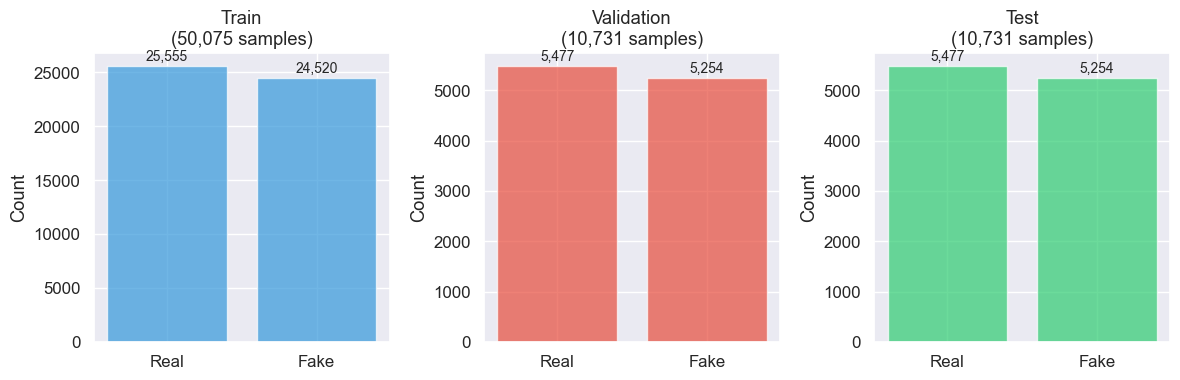

In [8]:
# Visualize splits
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (name, split_df) in enumerate(splits.items()):
    ax = axes[idx]
    counts = split_df['label'].value_counts()
    
    bars = ax.bar(['Real', 'Fake'], counts.values, color=colors[idx], alpha=0.7)
    ax.set_title(f'{name}\n({len(split_df):,} samples)')
    ax.set_ylabel('Count')
    
    # Add count labels
    for bar, count in zip(bars, counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
# Verify no data leakage
train_indices = split_indices['train_idx']
val_indices = split_indices['val_idx']
test_indices = split_indices['test_idx']

overlaps = [
    len(train_indices & val_indices),
    len(train_indices & test_indices), 
    len(val_indices & test_indices)
]

if sum(overlaps) == 0:
    print("✓ No data leakage detected - all splits are properly separated")
else:
    print("✗ WARNING: Data leakage detected!")

print(f"Total samples across splits: {len(train_indices | val_indices | test_indices)}")
print(f"Original dataset size: {len(df)}")

✓ No data leakage detected - all splits are properly separated
Total samples across splits: 71537
Original dataset size: 71537


## Save the Splits

In [10]:
# Create directory and save splits
splits_dir = Path('../data/splits')
splits_dir.mkdir(exist_ok=True)

# Save each split
train_df.to_csv(splits_dir / 'train.csv', index=False)
val_df.to_csv(splits_dir / 'validation.csv', index=False)
test_df.to_csv(splits_dir / 'test.csv', index=False)

print(f"Splits saved to {splits_dir}/")
print("Files created:")
print("  • train.csv")
print("  • validation.csv") 
print("  • test.csv")

Splits saved to ../data/splits/
Files created:
  • train.csv
  • validation.csv
  • test.csv


## Summary

**Dataset Overview**
- **Total Articles**: 71,537
- **Class Balance**: 51.0% fake news, 49.0% real news
- **Text Feature**: Combined title + text content

**Splits Created**
- **Training Set**: 50,075 samples (70%) for model training
- **Validation Set**: 10,731 samples (15%) for hyperparameter tuning
- **Test Set**: 10,731 samples (15%) for final evaluation

**Quality Assurance**
- ✓ Stratified sampling maintains class balance across all splits
- ✓ No data leakage between train/validation/test sets
- ✓ All original samples accounted for in splits
- ✓ Random seed (42) ensures reproducible results